# Simple MCMC Chain

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import math
import pandas as pd
import scipy
import scipy.stats as stats
from scipy.optimize import minimize
import threading
import random
import time
import multiprocessing as mp

In [6]:
FOGGY = np.array([0.5, 0.25, 0.25])
SUNNY = np.array([0.5, 0, 0.5])
RAINY = np.array([0.25, 0.25, 0.5])

parameter = ["Foggy", "Sunny", "Rainy"]

p = np.array([FOGGY, SUNNY, RAINY])
print(p)

Prediction_Days = 25

[[0.5  0.25 0.25]
 [0.5  0.   0.5 ]
 [0.25 0.25 0.5 ]]


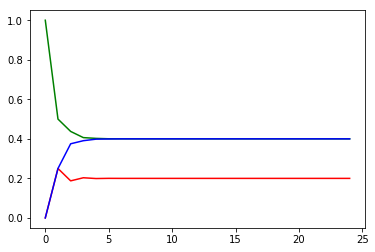

In [7]:
CurrentStateProb = [[0, 0, 0]] * Prediction_Days
CurrentStateProb[0] = [1, 0, 0]
#print(CurrentStateProb[1])

for i in range(1, Prediction_Days):
    Prob = np.matmul(CurrentStateProb[i - 1], p)
    CurrentStateProb[i] = list(Prob)

#print(CurrentStateProb[24])

Foggy, Sunny, Rainy = [], [], []
for i in range(0, Prediction_Days):
    Foggy.append(CurrentStateProb[i][0])
    Sunny.append(CurrentStateProb[i][1])
    Rainy.append(CurrentStateProb[i][2])

plt.plot(Foggy, 'g')
plt.plot(Sunny, 'r')
plt.plot(Rainy, 'b')
plt.show()

In [2]:
alpha_true = -2
beta_true = -5
time = list(range(1,11))

y_true = [alpha_true*time[i] + beta_true for i in range(0,10)]
sigma = 1
meas_err = np.random.normal(loc = 0, scale = sigma, size = len(time))
y = y_true + meas_err

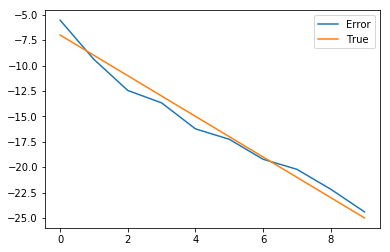

In [3]:
plt.plot(y,label='Error')
plt.plot(y_true,label='True')
#plt.plot(y_true,label='True')
plt.legend()
plt.show()

In [37]:
def logp(theta, time, y, sigma=1):
    N = len(time)
    alpha, beta = theta[0], theta[1]
    model = [alpha * time[i] + beta for i in range(0, 10)]
    resid = y - model
    log_likelihood = -N / 2 * math.log(
        2 * math.pi) - N * math.log(sigma) - 1 / 2 * sum(resid**2) / sigma**2
    log_prior = 0  # log(1)
    log_posterior = log_likelihood + log_prior
    return log_posterior

In [48]:
N = 30000
alpha_init = np.random.randint(-50,50)
beta_init = np.random.randint(-50,50)
theta = [alpha_init,beta_init]

In [59]:
print(theta)

[-1.865123669160924, -5.797536705061779]


In [60]:
lp = logp(theta,time,y)

In [61]:
theta_best = theta
lp_max = lp
theta_new = [0] * 2
accepts = 0
mcmc_chains = [[0, 0]] * N
step = [.1, 1]
time = list(range(1, 11))
# Defining variables for Adaptive metropolis Hastings -

for i in range(N):

    #print(step)
    theta_new = list(stats.norm.rvs(theta, step))
    lp_new = logp(theta_new, time, y)
    lq = lp_new - lp
    lr = math.log(np.random.uniform(0, 1))
    if (lr < lq):
        theta = theta_new
        lp = lp_new
        accepts += 1
        if lp > lp_max:
            theta_best = theta
            lp_max = lp
    mcmc_chains[i] = theta

In [62]:
print(accepts/N*100)
mcmc_chains = np.array(mcmc_chains)

27.48


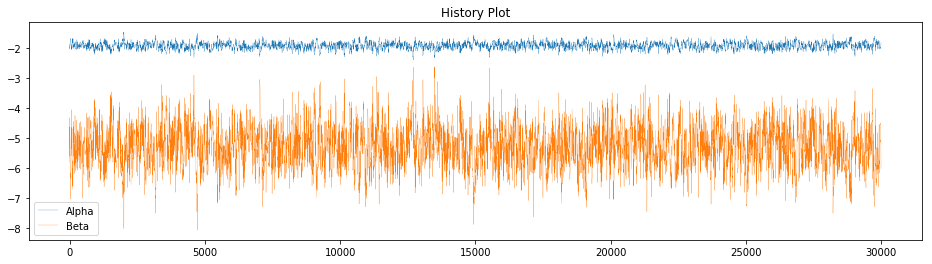

In [63]:
plt.figure(figsize=(16, 4))
plt.plot(mcmc_chains[:, 0], linewidth=0.25, label='Alpha')
plt.plot(mcmc_chains[:, 1], linewidth=0.25, label='Beta')
plt.title('History Plot')
plt.legend()
plt.show()
alpha = [mcmc_chains[i][0] for i in range(len(mcmc_chains))]
beta = [mcmc_chains[i][1] for i in range(len(mcmc_chains))]

In [64]:
def plot_graph_beta(mcmc_chains):
    beta = mcmc_chains[:,1]
    cor, r, flag = [], None, True
    for lag in range(1, 1500):
        X, Y = [], []
        X = beta[:len(beta) - lag]
        Y = beta[lag:]
        cor.append(np.corrcoef(X, Y, rowvar=False)[0][1])
        if flag and cor[lag - 1] <= 0.05:
            flag = False
            r = lag
    plt.plot(range(1, 1500), cor)
    plt.plot([r, r], [-0.2, 1])
    title = 'Beta Correlation'
    plt.title(title)
    plt.xlabel('Lag')
    plt.ylabel('correlation')
    plt.show()
    return r


def plot_graph_alpha(mcmc_chains):
    alpha = mcmc_chains[:,0]
    cor, r, flag = [], None, True
    for lag in range(1, 1500):
        X, Y = [], []
        X = alpha[:len(alpha) - lag]
        Y = alpha[lag:]
        cor.append(np.corrcoef(X, Y, rowvar=False)[0][1])
        if flag and cor[lag - 1] <= 0.05:
            flag = False
            r = lag
    plt.plot(range(1, 1500), cor)
    plt.plot([r, r], [-0.2, 1])
    title = 'Alpha Correlation'
    plt.title(title)
    plt.xlabel('Lag')
    plt.ylabel('correlation')
    plt.show()
    return r

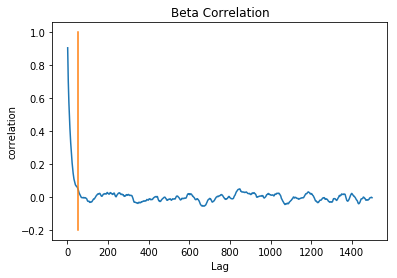

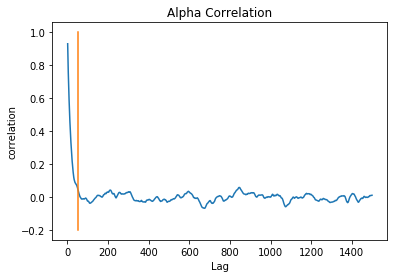

In [65]:
lag1 = plot_graph_beta(mcmc_chains)
lag2= plot_graph_alpha(mcmc_chains)

In [66]:
print(lag1)
print(lag2)
alpha1, beta1 = [], []
jump = lag1 if lag1 > lag2 else lag2
for i in range(0, len(mcmc_chains), jump):
    alpha1.append(mcmc_chains[i][0])
    beta1.append(mcmc_chains[i][1])
print('Alpha estimate', np.mean(alpha1))
print('Beta estimate', np.mean(beta1))

52
51
Alpha estimate -1.924661250240183
Beta estimate -5.2843617682619115


## Trying out Gelman-Rubin convergence diagnostic

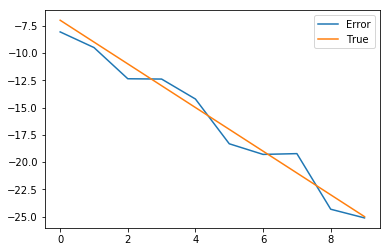

Random estimate for parameters - [20, -45]


In [6]:
alpha_true = -2
beta_true = -5
time = list(range(1, 11))

y_true = [alpha_true * time[i] + beta_true for i in range(0, 10)]
sigma = 1
meas_err = np.random.normal(loc=0, scale=sigma, size=len(time))
y = y_true + meas_err
plt.plot(y, label='Error')

plt.plot(y_true, label='True')
#plt.plot(y_true,label='True')
plt.legend()
plt.show()

N = 30000
alpha_init = np.random.randint(-50, 50)
beta_init = np.random.randint(-50, 50)
theta = [alpha_init, beta_init]
print('Random estimate for parameters -', theta)

lp = logp(theta, time, y)
theta_best = theta
lp_max = lp
theta_new = [0] * 2
accepts = 0
mcmc_chains = [[0., 0.]] * N
mcmc_chains = np.array(mcmc_chains)
step = np.array([[.1,0],[0,1]])
time = list(range(1, 11))
# Defining variables for Adaptive metropolis Hastings -
sd = 2.38**2/2

for i in range(N):
    step = sd*(np.cov(np.transpose(mcmc_chains[:i,:]))) if i > 1000 else step
    theta_new = list(np.random.multivariate_normal(mean=theta,cov= step))
    lp_new = logp(theta_new, time, y)
    lq = lp_new - lp
    lr = math.log(np.random.uniform(0, 1))
    if (lr < lq):
        theta = theta_new
        lp = lp_new
        accepts += 1
        if lp > lp_max:
            theta_best = theta
            lp_max = lp
    mcmc_chains[i] = theta
    #print(theta)
    

Acceptance Rate - 1.3733333333333333


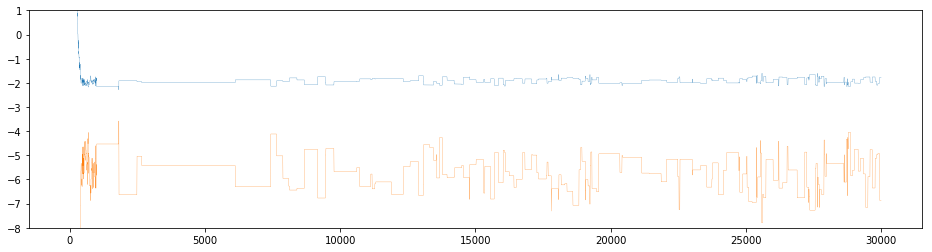

In [7]:
print('Acceptance Rate -', accepts / N * 100)
plt.figure(figsize=(16, 4))
plt.ylim(-8,1)
plt.plot(mcmc_chains, linewidth=0.25)
plt.show()

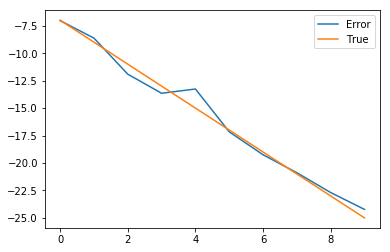

In [6]:
y_true = [alpha_true * time[i] + beta_true for i in range(0, 10)]
sigma = 1
meas_err = np.random.normal(loc=0, scale=sigma, size=len(time))
y = y_true + meas_err
plt.plot(y, label='Error')

plt.plot(y_true, label='True')
#plt.plot(y_true,label='True')
plt.legend()
plt.show()

def chain(N = 30000):
    time = list(range(1, 11))
    alpha_init = np.random.randint(-50, 50)
    beta_init = np.random.randint(-50, 50)
    theta = [alpha_init, beta_init]
    print('Random estimate for parameters -', theta)

    lp = logp(theta, time, y)
    theta_best = theta
    lp_max = lp
    theta_new = [0] * 2
    accepts = 0
    mcmc_chains = [[0., 0.]] * N
    mcmc_chains = np.array(mcmc_chains)
    step = np.array([.1, 1])
    time = list(range(1, 11))
    # Defining variables for Adaptive metropolis Hastings -
    sd = 2.38**2/2

    for i in range(N):
        theta_new = list(stats.norm.rvs(theta, step))
        lp_new = logp(theta_new, time, y)
        lq = lp_new - lp
        lr = math.log(np.random.uniform(0, 1))
        if (lr < lq):
            theta = theta_new
            lp = lp_new
            accepts += 1
            if lp > lp_max:
                theta_best = theta
                lp_max = lp
        mcmc_chains[i] = theta
    return mcmc_chains

In [7]:
mcmc_chains = []
N = 30000
m = 10
for i in range(10):
    mcmc_chains.append(chain(N))
mcmc_chains = np.array(mcmc_chains)

Random estimate for parameters - [2, 42]
Random estimate for parameters - [27, 26]
Random estimate for parameters - [33, 9]
Random estimate for parameters - [-9, -6]
Random estimate for parameters - [16, -44]
Random estimate for parameters - [-16, -45]
Random estimate for parameters - [-4, 48]
Random estimate for parameters - [40, -50]
Random estimate for parameters - [35, -44]
Random estimate for parameters - [47, -31]


In [8]:
#Number of chains

def diagnsotic(mcmc_chains):
    m = len(mcmc_chains)
    s_j = [np.var(mcmc_chains[i]) for i in range(m)]
    W = 1 / m * np.sum(s_j)
    global_mean = np.mean([np.mean(mcmc_chains[i]) for i in range(m)])
    B = N / (m - 1) * np.sum([(np.mean(mcmc_chains[i]) - global_mean)**2
                              for i in range(m)])
    Var = (1 - 1/N)*W + 1/N*B
    return np.sqrt(Var/W)

In [13]:
R = (diagnsotic(mcmc_chains[:,0,:]))
burn_in = 1
while R >= 1.05:
    R = (diagnsotic(mcmc_chains[:,:burn_in,:]))
    burn_in += 100
    print(R)
R = (diagnsotic(mcmc_chains[:,burn_in:,:]))

1.21614540867578
1.1103384138661065
1.0643325852430756
1.0524458101763683
1.0540071789703747
1.0585976572143931
1.0644443587843349
1.0704802941039522
1.0750919290760772
1.0782674752692394
1.0799372198549575
1.0798409169742316
1.0779335884352947
1.0746504543064672
1.070658129667254
1.0661657452735958
1.061627790663143
1.0574784893942175
1.053816955550269
1.0505756515505362
1.0477280383733893


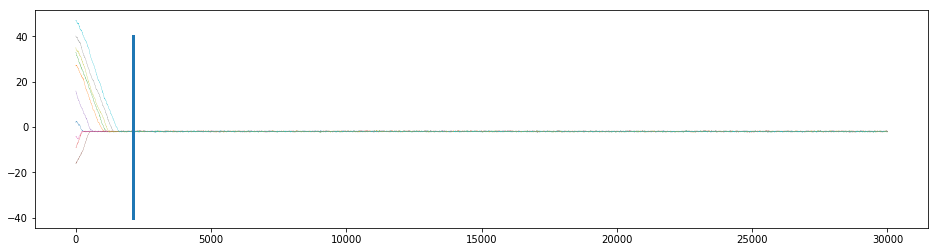

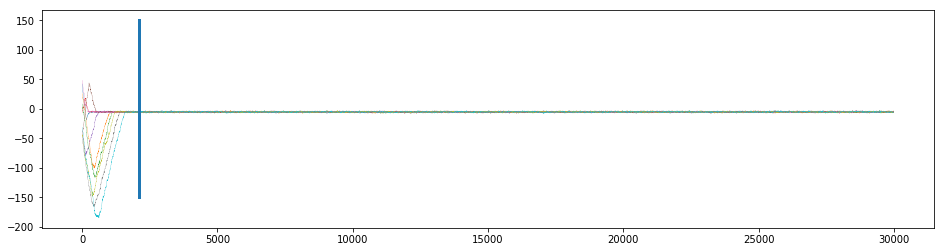

In [14]:
plt.figure(figsize=(16, 4))
for i in range(len(mcmc_chains)):
    plt.plot(mcmc_chains[i,:,0], linewidth=0.25, label='Alpha')
plt.plot([burn_in,burn_in],[-40,40], linewidth=3)
plt.figure(figsize=(16, 4))
for i in range(len(mcmc_chains)):
    plt.plot(mcmc_chains[i,:,1], linewidth=0.25, label='Alpha')
plt.plot([burn_in,burn_in],[-150,150], linewidth=3)
plt.show()
#plt.plot(mcmc_chains[:, 1], linewidth=0.25, label='Beta')
#plt.title('History Plot')
#plt.legend()
#plt.show()
#alpha = [mcmc_chains[i][0] for i in range(len(mcmc_chains))]
#beta = [mcmc_chains[i][1] for i in range(len(mcmc_chains))]

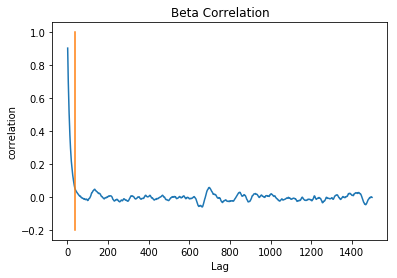

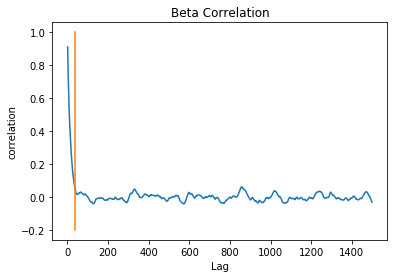

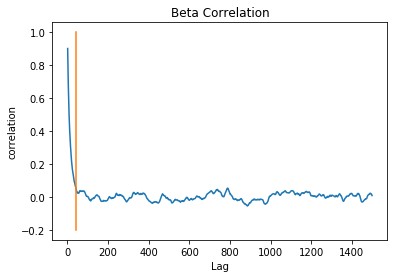

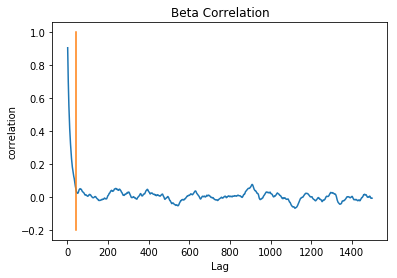

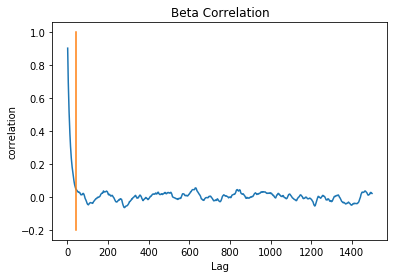

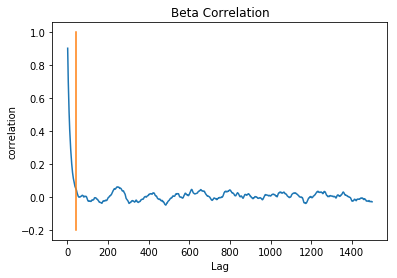

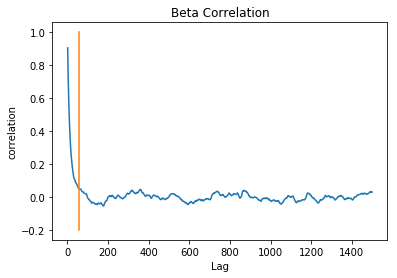

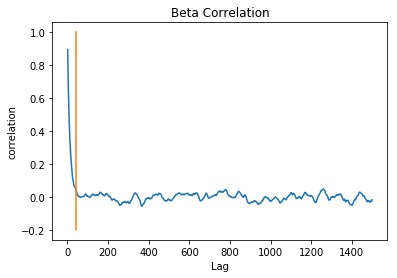

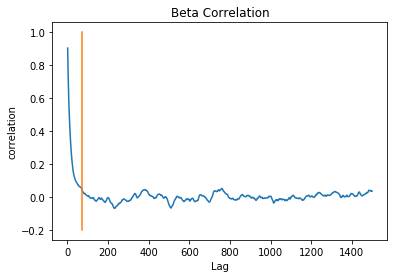

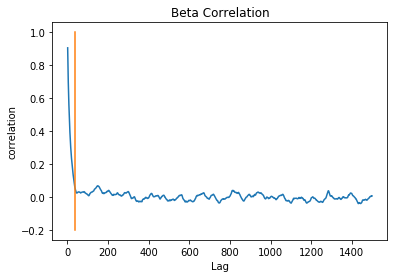

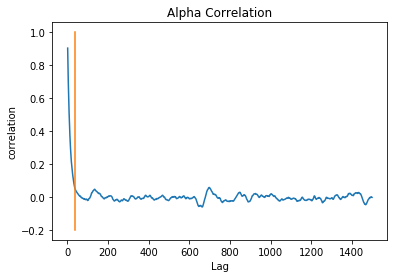

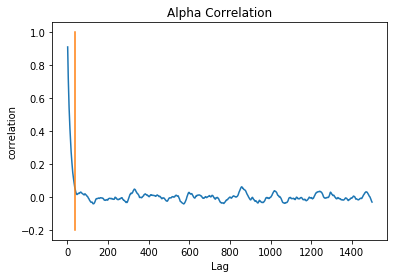

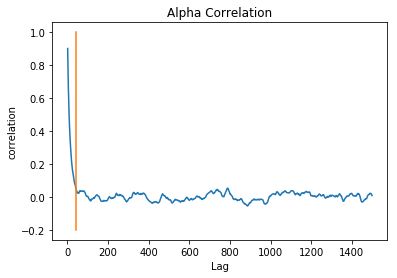

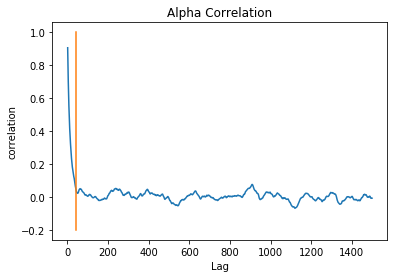

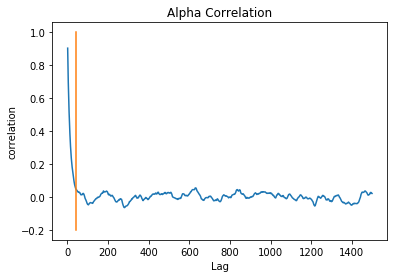

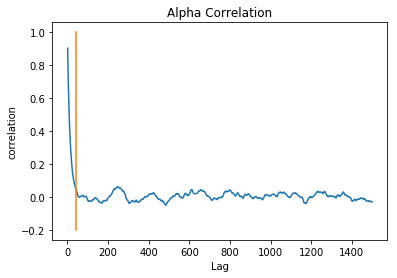

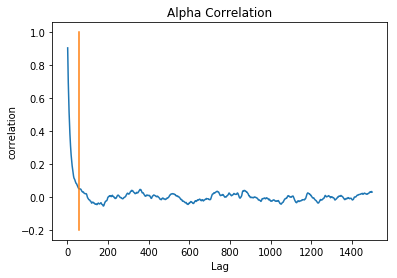

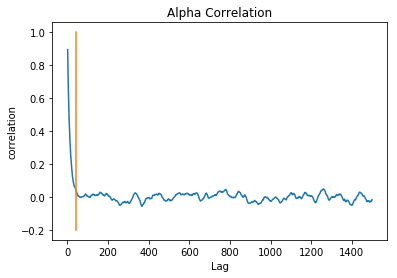

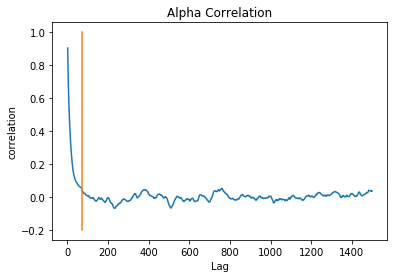

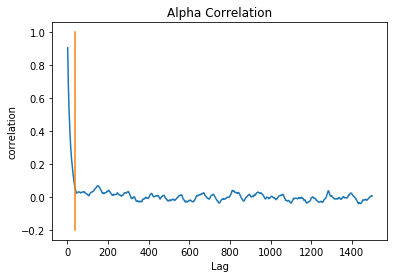

70


In [17]:
lag1 = [plot_graph_beta(mcmc_chains[i,burn_in:,:]) for i in range(len(mcmc_chains))]
lag2=  [plot_graph_alpha(mcmc_chains[i,burn_in:,:]) for i in range(len(mcmc_chains))]
lag = (np.max(lag1+lag2))
print(lag)
alpha1, beta1 = [], []

In [26]:
alpha_hist = []
for i in range(len(mcmc_chains)):
    for j in range(burn_in,len(mcmc_chains[i]),lag):
        alpha_hist.append(mcmc_chains[i,j,0])
beta_hist = []
for i in range(len(mcmc_chains)):
    for j in range(burn_in,len(mcmc_chains[i]),lag):
        beta_hist.append(mcmc_chains[i,j,1])

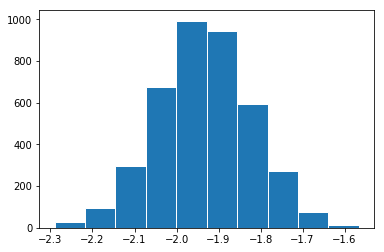

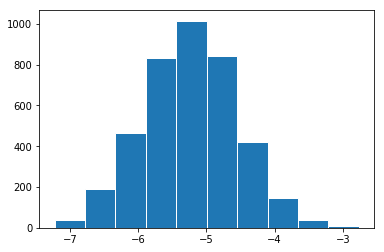

In [29]:
plt.hist(alpha_hist, edgecolor='white')
plt.show()
plt.hist(beta_hist, edgecolor = 'white')
plt.show()
alpha_CI = [np.percentile(alpha_hist, 5),np.percentile(alpha_hist, 95)]
beta_CI = [np.percentile(beta_hist, 5),np.percentile(beta_hist, 95)]

In [31]:
print(alpha_CI)
print(beta_CI)

[-2.11933358648127, -1.7482920540068476]
[-6.3796406245082, -4.114166946387731]


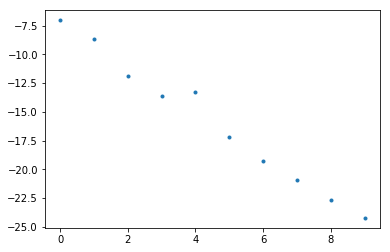

In [35]:
plt.plot(y,'.')
plt.show()

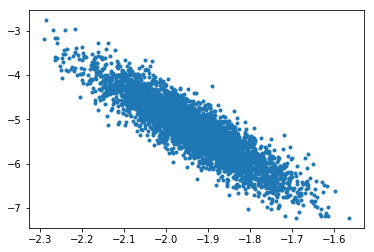

In [36]:
plt.plot(alpha_hist, beta_hist, '.')